# Project : ResNet Ablation Study

## 프로젝트 제출 루브릭
| 학습목표 | 평가기준 |
|----------|----------|
| ResNet-34, ResNet-50 모델 구현이 정상적으로 진행되었는가? | 블록함수 구현이 제대로 진행되었으며 구현한 모델의 summary가 예상된 형태로 출력되었다. |
| 구현한 ResNet 모델을 활용하여 Image Classification 모델 훈련이 가능한가? | tensorflow-datasets에서 제공하는 cats_vs_dogs 데이터셋으로 학습 진행 시 loss가 감소하는 것이 확인되었다. |
| Ablation Study 결과가 바른 포맷으로 제출되었는가? | ResNet-34, ResNet-50 각각 plain모델과 residual모델을 동일한 epoch만큼 학습시켰을 때의 validation accuracy 기준으로 Ablation Study 결과표가 작성되었다. |


# 1. Library & Data

In [40]:
# Pytorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

In [9]:
# 논문 기준 ImageNet으로 batch_size 256으로 지정했다고 함.
BATCH_SIZE = 256

# CIFAR-10 데이터셋에 대해 Normalize와 Tensor 변환을 적용하는 코드
# 다만 논문 속에서는 augmentation을 추가로 했다고 하지만..
# 안하려 했는데, epoch를 늘릴경우, 과적합 위험이 높아져서 논문 상에서 구현한거만 진행
# 4픽셀 Padding 후 32->40 사이즈로 변경
# 무작위로 32×32 크기의 영역을 뽑음
# 뽑은 영역에 좌우 반전을 적용
transform_train = transforms.Compose([
    transforms.Pad(4),  # 4픽셀 패딩
    transforms.RandomCrop(32),  # 32x32 랜덤 크롭
    transforms.RandomHorizontalFlip(),  # 좌우 반전
    transforms.ToTensor(),  # Tensor로 변환
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])  # 정규화
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std=[0.2470, 0.2435, 0.2616])
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
# 데이터셋을 로드하고 기본 정보를 확인해 보세요.
image, label = trainset[0]

print(f"Image shape: {image.shape}")
print(f"Label: {label}")
print(f"Number of classes: {len(trainset.classes)}")

Image shape: torch.Size([3, 32, 32])
Label: 6
Number of classes: 10


In [11]:
# 데이터의 개수도 확인해 봅시다.
train_size = torch.tensor(len(trainset))
test_size = torch.tensor(len(testset))

print(f"Train dataset size: {train_size} (Shape: {train_size.shape})")
print(f"Test dataset size: {test_size} (Shape: {test_size.shape})")

Train dataset size: 50000 (Shape: torch.Size([]))
Test dataset size: 10000 (Shape: torch.Size([]))


In [12]:
class_names = trainset.classes
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


# 2. ResNet
## 2-1. ResNet Block
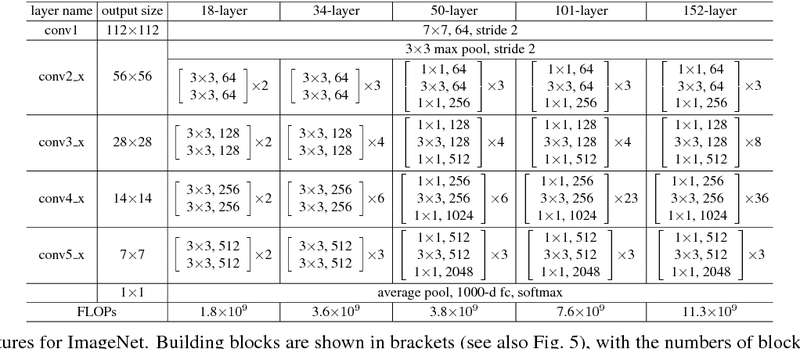

In [18]:
def build_resnet_block(input_layer,
                        num_blocks=[3,4,6,3],
                        channels=[64,128,256,512],
                        is_50=False):
    """
    input_channels: 입력 feature map의 채널 수
    num_cnn: 각 stage별 residual block 개수
    channels: 각 stage별 출력 채널 수
    is_50: True -> ResNet-50 Bottleneck, False -> ResNet-34 Basic
    """
    
    assert len(num_blocks) == len(channels), "num_cnn과 channel 길이 불일치"
    x = input_layer
    layers = []


    # -----------------------------
    # if문 전에 공통 초기 레이어
    # Conv7x7 -> BN -> ReLU -> MaxPool
    # -----------------------------
    in_channels = x.size(1)
    layers.append(nn.Conv2d(in_channels, 64, kernel_size=7, stride=2, padding=3, bias=False))
    layers.append(nn.BatchNorm2d(64))
    layers.append(nn.ReLU(inplace=True))
    layers.append(nn.MaxPool2d(kernel_size=3, stride=2, padding=1))
    in_channels = 64 # 공통 사항 

    # 각 Residual Block 내부에서는 MaxPooling 없음. 최종 FC 레이어 직전에만 Global Average Pooling 적용
    # 2015 ResNet 논문은 Post-Activation, 2016 Pre-Activation ResNet에서는 BN->ReLU->Conv 순서 사용
    # 층 개수가 50을 기준으로 Basic이냐 Bottleneck이냐 갈림 
    # 각 Block 들어갈때, stride는 2로 하고, 이후에는 1로 진행한다.
    # 
    if is_50: # Bottleneck 
        for stage_idx, (num_block, out_ch) in enumerate(zip(num_blocks, channels)):
            for block_idx in range(num_block):
                stride = 2 if block_idx == 0 and stage_idx != 0 else 1
                bottleneck_channels = out_ch // 4

                # Post-activation: Conv → BN → ReLU
                # bottleneck 구조: 1x1 Conv로 채널 수를 줄였다가(압축), 3x3 Conv 진행 후 1x1 Conv로 다시 out_ch로 확장
                conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False)
                bn1 = nn.BatchNorm2d(bottleneck_channels)

                conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3,
                                  stride=stride, padding=1, bias=False)
                bn2 = nn.BatchNorm2d(bottleneck_channels)

                conv3 = nn.Conv2d(bottleneck_channels, out_ch, kernel_size=1, stride=1, bias=False)
                bn3 = nn.BatchNorm2d(out_ch)

                # Skip connection
                # 다만 이 블록 함수가 아니라 실제 동작은 model class의 forward에서 진행됨
                downsample = None
                if stride != 1 or in_channels != out_ch:
                    downsample = nn.Conv2d(in_channels, out_ch, kernel_size=1, stride=stride, bias=False)

                # Block 순서: Conv → BN → ReLU ...
                block_layers = nn.ModuleList([
                    conv1, bn1, nn.ReLU(inplace=True),
                    conv2, bn2, nn.ReLU(inplace=True),
                    conv3, bn3, nn.ReLU(inplace=True)
                ])

                # Skip 연결 포함
                if downsample is not None:
                    block_layers.append(downsample)

                layers.append(nn.Sequential(*block_layers))
                in_channels = out_ch

    else: # Basic Block
        for stage_idx, (num_block, out_ch) in enumerate(zip(num_blocks, channels)):
            for block_idx in range(num_block):
                stride = 2 if block_idx == 0 and stage_idx != 0 else 1

                conv1 = nn.Conv2d(in_channels, out_ch, kernel_size=3, stride=stride, padding=1, bias=False)
                bn1 = nn.BatchNorm2d(out_ch)

                conv2 = nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1, bias=False)
                bn2 = nn.BatchNorm2d(out_ch)

                # Skip connection
                downsample = None
                if stride != 1 or in_channels != out_ch:
                    downsample = nn.Conv2d(in_channels, out_ch, kernel_size=1, stride=stride, bias=False)

                # Block 순서: Conv → BN → ReLU ...
                block_layers = nn.ModuleList([
                    conv1, bn1, nn.ReLU(inplace=True),
                    conv2, bn2, nn.ReLU(inplace=True)
                ])

                if downsample is not None:
                    block_layers.append(downsample)

                layers.append(nn.Sequential(*block_layers))
                in_channels = out_ch

    return nn.Sequential(*layers)


In [19]:
build_resnet_block(torch.zeros(1, 3, 32, 32))

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
  )
  (5): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 

In [20]:
build_resnet_block(torch.zeros(1, 3, 32, 32),
                   num_blocks=[3,4,6,3],
                   channels=[256, 512, 1024, 2048],
                   is_50=True)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  )
  (5): Sequential(
    (0): Conv

## 2-2. ResNet Class - 34 & 50

In [21]:
class BasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BasicBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.downsample is not None:
            identity = self.downsample(identity)
        
        out += identity
        out = F.relu(out)
        return out

In [22]:
class BottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(BottleneckBlock, self).__init__()
        bottleneck_channels = out_channels // 4

        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

        # Downsample shortcut: Conv + BN
        self.downsample = None
        if stride != 1 or in_channels != out_channels:
            self.downsample = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(identity)

        out += identity
        out = F.relu(out)
        return out

In [23]:
class ResNet(nn.Module):
    def __init__(self, num_blocks=[3,4,6,3], channels=[64,128,256,512],
                 is_50=False, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.stages = nn.ModuleList()
        for stage_idx, (num_block, out_ch) in enumerate(zip(num_blocks, channels)):
            blocks = []
            for block_idx in range(num_block):
                stride = 2 if block_idx == 0 and stage_idx != 0 else 1
                if is_50:
                    blocks.append(BottleneckBlock(self.in_channels, out_ch, stride=stride))
                else:
                    blocks.append(BasicBlock(self.in_channels, out_ch, stride=stride))
                self.in_channels = out_ch
            self.stages.append(nn.ModuleList(blocks))

        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for stage in self.stages:
            for block in stage:
                x = block(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

## 2-3. 내가 짠?? Model Class의 구조와 실제 구현된 모델의 구조 비교

In [24]:
# resnet34 비교하기
resnet34 = ResNet(is_50=False, num_classes=10)
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): ModuleList(
    (0): ModuleList(
      (0-2): 3 x BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ModuleList(
      (0): BasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=

In [25]:
resnet50 = ResNet(
    num_blocks=[3, 4, 6, 3],
    channels=[256, 512, 1024, 2048],
    is_50=True,
    num_classes=10
)
print(resnet50)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): ModuleList(
    (0): ModuleList(
      (0): BottleneckBlock(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_size=(1, 1), 

In [26]:
import torchvision.models as models

resnet34 = models.resnet34()
print(resnet34)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# 3. Plain Class

In [27]:
class PlainBasicBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)
        return out

class PlainBottleneckBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(PlainBottleneckBlock, self).__init__()
        bottleneck_channels = out_channels // 4

        self.conv1 = nn.Conv2d(in_channels, bottleneck_channels, kernel_size=1, stride=1, bias=False)
        self.bn1 = nn.BatchNorm2d(bottleneck_channels)

        self.conv2 = nn.Conv2d(bottleneck_channels, bottleneck_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(bottleneck_channels)

        self.conv3 = nn.Conv2d(bottleneck_channels, out_channels, kernel_size=1, stride=1, bias=False)
        self.bn3 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = F.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)
        out = F.relu(out)
        return out

In [28]:
class PlainResNet(nn.Module):
    def __init__(self, num_blocks=[3,4,6,3], channels=[64,128,256,512],
                 is_50=False, num_classes=10):
        super(PlainResNet, self).__init__()
        self.in_channels = 64

        # 초기 레이어
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # Residual Stages 대신 Plain Blocks
        self.stages = nn.ModuleList()
        for stage_idx, (num_block, out_ch) in enumerate(zip(num_blocks, channels)):
            blocks = []
            for block_idx in range(num_block):
                stride = 2 if block_idx == 0 and stage_idx != 0 else 1
                if is_50:
                    blocks.append(PlainBottleneckBlock(self.in_channels, out_ch, stride=stride))
                else:
                    blocks.append(PlainBasicBlock(self.in_channels, out_ch, stride=stride))
                self.in_channels = out_ch
            self.stages.append(nn.ModuleList(blocks))

        # Classifier
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))
        self.fc = nn.Linear(self.in_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        for stage in self.stages:
            for block in stage:
                x = block(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [29]:
# resnet34 비교하기
plain34 = PlainResNet(is_50=False, num_classes=10)
print(plain34)

PlainResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (stages): ModuleList(
    (0): ModuleList(
      (0-2): 3 x PlainBasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): ModuleList(
      (0): PlainBasicBlock(
        (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track

# 4. ResNet-34 vs Plain-34 또는 ResNet-50 vs Plain-50 Train & Test

In [33]:
import time
import torch.optim as optim
from torch.optim.lr_scheduler import LinearLR, MultiStepLR, SequentialLR
import json
import os

def create_lr_scheduler(optimizer, iters_per_epoch):
    """논문 기준의 Warm-up + Step-Decay 스케줄러를 생성합니다."""
    WARMUP_ITERS = 400
    STEP_DECAY_ITERS_1 = 32000
    STEP_DECAY_ITERS_2 = 48000
    
    warmup_scheduler = LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=WARMUP_ITERS)
    main_milestones = [STEP_DECAY_ITERS_1 - WARMUP_ITERS, 
                       STEP_DECAY_ITERS_2 - WARMUP_ITERS]
    main_scheduler = MultiStepLR(optimizer, milestones=main_milestones, gamma=0.1)
    scheduler = SequentialLR(optimizer, 
                             schedulers=[warmup_scheduler, main_scheduler], 
                             milestones=[WARMUP_ITERS])
    return scheduler


def train_model(model, model_name, train_loader, test_loader, epochs, device, optimizer, path="model/"):

    print(f"\n--- Training {model_name} ---")
    
    iters_per_epoch = len(train_loader)
    scheduler = create_lr_scheduler(optimizer, iters_per_epoch)
    
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}
    
    best_val_acc = 0.0 

    for epoch in range(epochs):
        model.train() 
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        start_time = time.time()
        
        for i, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            

            running_loss += loss.item()
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
            scheduler.step()         

        model.eval() 
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                
                val_loss = criterion(outputs, labels)
                running_val_loss += val_loss.item()
                
                _, predicted_val = torch.max(outputs.data, 1)
                total_val += labels.size(0)
                correct_val += (predicted_val == labels).sum().item()
        
  
        epoch_loss = running_loss / len(train_loader)
        epoch_train_acc = 100 * correct_train / total_train
        epoch_val_loss = running_val_loss / len(test_loader)
        epoch_val_acc = 100 * correct_val / total_val
        
        epoch_time = time.time() - start_time
        current_lr = optimizer.param_groups[0]['lr']
        
        print(f"Epoch [{epoch+1}/{epochs}], Time: {epoch_time:.2f}s")
        print(f"  Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_train_acc:.2f}%")
        print(f"  Val Loss: {epoch_val_loss:.4f}, Val Acc: {epoch_val_acc:.2f}%, LR: {current_lr:.6f}")
        
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            save_path = os.path.join(path, f"{model_name}_best_model.pth")
            torch.save(model.state_dict(), save_path)
            print(f"  New best model found! Saving to '{save_path}' (Val Acc: {best_val_acc:.2f}%)")

        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_train_acc)
        history['val_loss'].append(epoch_val_loss)
        history['val_acc'].append(epoch_val_acc)
        history['lr'].append(current_lr) 
            

    history_save_path = os.path.join(path, f"{model_name}_history.json")
    try:
        serializable_history = {k: [float(item) for item in v] for k, v in history.items()}
        with open(history_save_path, 'w') as f:
            json.dump(serializable_history, f, indent=4)
        print(f"  Successfully saved history to '{history_save_path}'")
    except Exception as e:
        print(f"  Error saving history: {e}")
            
    print(f"--- Finished Training {model_name} ---")
    return history

In [37]:
# 하이퍼파라미터 (논문 기준)
LR = 0.1 # 논문 기준 초기 LR
MOMENTUM = 0.9
WEIGHT_DECAY = 0.0001


EPOCH = 15
criterion = nn.CrossEntropyLoss()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 모델 정의 
models_to_train = {
    "ResNet-34": ResNet(num_blocks=[3, 4, 6, 3], is_50=False, num_classes=10).to(device),
    "Plain-34": PlainResNet(num_blocks=[3, 4, 6, 3], is_50=False, num_classes=10).to(device),
    "ResNet-50": ResNet(num_blocks=[3, 4, 6, 3], channels=[256, 512, 1024, 2048], is_50=True, num_classes=10).to(device),
    "Plain-50": PlainResNet(num_blocks=[3, 4, 6, 3], channels=[256, 512, 1024, 2048], is_50=True, num_classes=10).to(device)
}


all_histories = {}

iters_per_epoch = len(trainloader) 
total_iters_notebook = EPOCH * iters_per_epoch 
print(f"--- LR Schedule Configuration ---")
print(f"Total iterations for {EPOCH} epochs: {total_iters_notebook}")
print(f"WARNING: 현재 EPOCH 설정({EPOCH})으로는 논문의 LR Step Decay(32k, 48k iter) 시점에 도달하지 않습니다.")
print(f"---------------------------------\n")

for model_name, model in models_to_train.items():
    optimizer = optim.SGD(model.parameters(), lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    history = train_model(model, model_name, trainloader, testloader, EPOCH, device, optimizer)
    all_histories[model_name] = history

print("\n\n--- All Training Finished ---")

Using device: cuda
--- LR Schedule Configuration ---
Total iterations for 15 epochs: 2940
---------------------------------
--- Training ResNet-34 ---
Epoch [1/15], Time: 29.10s
  Train Loss: 1.9157, Train Acc: 35.49%
  Val Loss: 2.1292, Val Acc: 38.92%, LR: 0.054100
Epoch [2/15], Time: 29.00s
  Train Loss: 1.7230, Train Acc: 43.06%
  Val Loss: 1.6385, Val Acc: 40.74%, LR: 0.098200
Epoch [3/15], Time: 29.19s
  Train Loss: 1.4237, Train Acc: 51.50%
  Val Loss: 1.3922, Val Acc: 55.73%, LR: 0.100000
Epoch [4/15], Time: 29.04s
  Train Loss: 1.1272, Train Acc: 61.33%
  Val Loss: 1.1078, Val Acc: 61.22%, LR: 0.100000
Epoch [5/15], Time: 29.08s
  Train Loss: 0.9352, Train Acc: 67.57%
  Val Loss: 1.1765, Val Acc: 60.05%, LR: 0.100000
Epoch [6/15], Time: 29.06s
  Train Loss: 0.8240, Train Acc: 71.17%
  Val Loss: 0.9152, Val Acc: 68.29%, LR: 0.100000
Epoch [7/15], Time: 29.08s
  Train Loss: 0.6986, Train Acc: 75.64%
  Val Loss: 0.8559, Val Acc: 70.12%, LR: 0.100000
Epoch [8/15], Time: 29.19s
  T

# 5. 시각화 및 지표

In [38]:
def plot_comparison(history1, name1, history2, name2, title_prefix, filename, colors=('blue', 'orange')):
    """두 모델의 4가지 지표(Train/Val Loss, Train/Val Acc)를 2x2로 비교합니다."""
    
    plt.figure(figsize=(14, 10))
    plt.suptitle(f'{title_prefix} Model Comparison ({EPOCH} Epochs)', fontsize=16)

    # Train Loss
    plt.subplot(2, 2, 1)
    plt.plot(history1['train_loss'], label=f'{name1} Train Loss', color=colors[0])
    plt.plot(history2['train_loss'], label=f'{name2} Train Loss', color=colors[1])
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Validation Loss
    plt.subplot(2, 2, 2)
    plt.plot(history1['val_loss'], label=f'{name1} Val Loss', color=colors[0])
    plt.plot(history2['val_loss'], label=f'{name2} Val Loss', color=colors[1])
    plt.title('Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Train Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(history1['train_acc'], label=f'{name1} Train Acc', color=colors[0])
    plt.plot(history2['train_acc'], label=f'{name2} Train Acc', color=colors[1])
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    # Validation Accuracy
    plt.subplot(2, 2, 4)
    plt.plot(history1['val_acc'], label=f'{name1} Val Acc', color=colors[0])
    plt.plot(history2['val_acc'], label=f'{name2} Val Acc', color=colors[1])
    plt.title('Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.close()

# --- 결과표 출력 함수 (루브릭 기준) ---
def print_results_table(histories_dict, score='val_acc'):
    """루브릭 요구사항에 맞는 최종 결과표를 출력합니다."""
    print("\n\n--- Ablation Study Results (Final Validation Accuracy) ---")
    print("| Model | Validation Accuracy (at 15 Epochs) |")
    print("|---|---|")
    print(f"| ResNet-34 | {histories_dict['ResNet-34'][score][-1]:.2f}% |")
    print(f"| Plain-34 | {histories_dict['Plain-34'][score][-1]:.2f}% |")
    print(f"| ResNet-50 | {histories_dict['ResNet-50'][score][-1]:.2f}% |")
    print(f"| Plain-50 | {histories_dict['Plain-50'][score][-1]:.2f}% |")

[Plotting] Generating comparison graphs...
[Saved] 34-Layer comparison plot: 'comparison_34_layer.png'
[Saved] 50-Layer comparison plot: 'comparison_50_layer.png'


--- Ablation Study Results (Final Validation Accuracy) ---
| Model | Validation Accuracy (at 15 Epochs) |
|---|---|
| ResNet-34 | 71.59% |
| Plain-34 | 25.77% |
| ResNet-50 | 67.09% |
| Plain-50 | 28.15% |


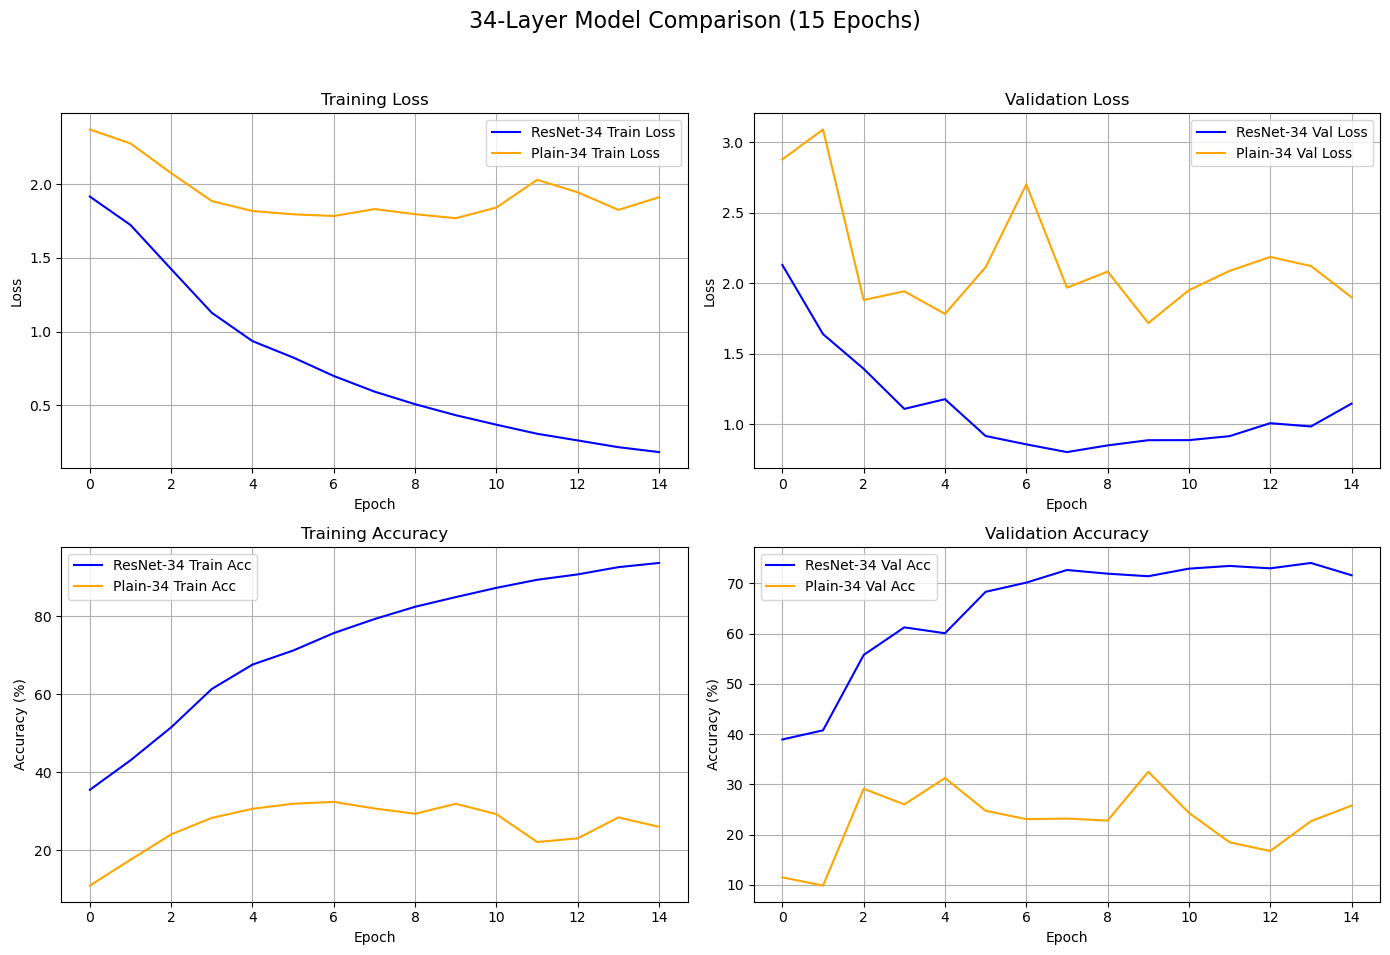

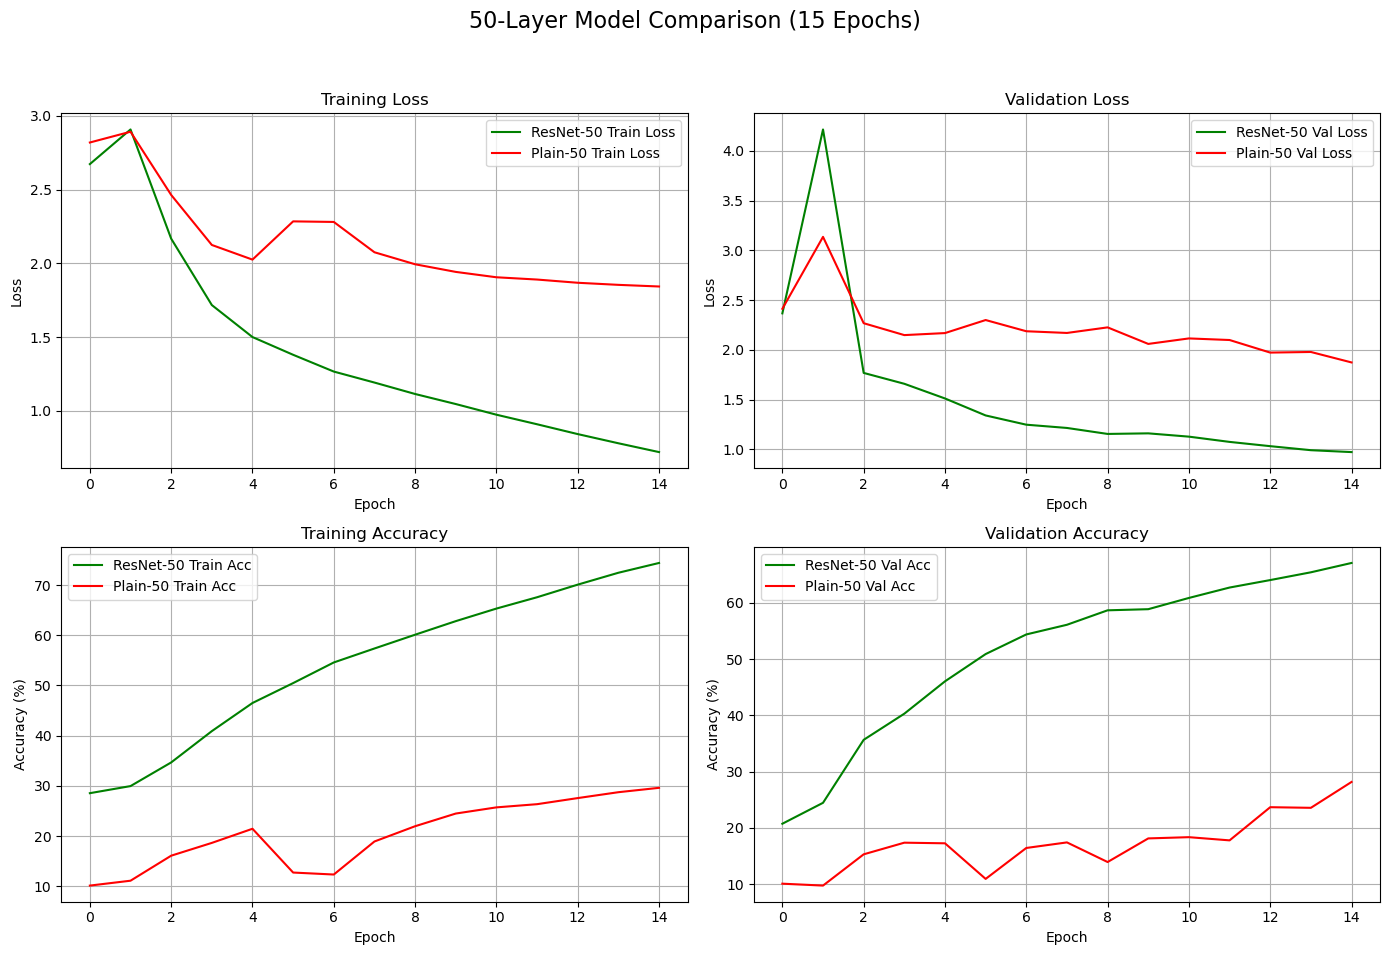

In [39]:
# 34-Layer 비교 (4가지 지표)
plot_comparison(all_histories['ResNet-34'], 'ResNet-34', 
                    all_histories['Plain-34'], 'Plain-34', 
                    '34-Layer', 'comparison_34_layer.png', colors=('blue', 'orange'))
    
# 50-Layer 비교 (4가지 지표)
plot_comparison(all_histories['ResNet-50'], 'ResNet-50', 
                    all_histories['Plain-50'], 'Plain-50', 
                    '50-Layer', 'comparison_50_layer.png', colors=('green', 'red'))
    
print_results_table(all_histories)


In [ ]:
def evaluate_model(model, model_name, weights_path, test_loader, device):
    """저장된 모델 가중치를 불러와 테스트 데이터셋으로 정확도를 평가합니다."""
    
    print(f"\nEvaluating {model_name}...")
    try:

        model.load_state_dict(torch.load(weights_path, map_location=device))
    except FileNotFoundError:
        print(f"  ERROR: Weights file not found at {weights_path}")
        return None
    except Exception as e:
        print(f"  ERROR loading weights for {model_name}: {e}")
        return None
        
    model.to(device)
    model.eval()
    
    correct = 0
    total = 0
    
 
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            outputs = model(inputs)
            

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f"  Test Accuracy for {model_name}: {accuracy:.2f}%")
    return accuracy


SAVE_PATH = "model/" 

models_to_evaluate = {
    "ResNet-34": ResNet(num_blocks=[3, 4, 6, 3], is_50=False, num_classes=10),
    "Plain-34": PlainResNet(num_blocks=[3, 4, 6, 3], is_50=False, num_classes=10),
    "ResNet-50": ResNet(num_blocks=[3, 4, 6, 3], channels=[256, 512, 1024, 2048], is_50=True, num_classes=10),
    "Plain-50": PlainResNet(num_blocks=[3, 4, 6, 3], channels=[256, 512, 1024, 2048], is_50=True, num_classes=10)
}

test_results = {}

print("--- 🧪 Starting Final Model Evaluation on Test Data ---")
print(f"(Loading best models from '{SAVE_PATH}' directory)")

for model_name, model_instance in models_to_evaluate.items():
    weights_file = os.path.join(SAVE_PATH, f"{model_name}_best_model.pth")
    
    acc = evaluate_model(model_instance, model_name, weights_file, testloader, device)
    test_results[model_name] = acc

# 4. 최종 결과표 출력 (Test Accuracy 기준)
print("\n\n--- Ablation Study Results (Final Test Accuracy) ---")
print("| Model | Test Accuracy (from best .pth) |")
print("|---|---|")

res34_acc = f"{test_results.get('ResNet-34', 0.0):.2f}%" if test_results.get('ResNet-34') else "N/A (Load Failed)"
plain34_acc = f"{test_results.get('Plain-34', 0.0):.2f}%" if test_results.get('Plain-34') else "N/A (Load Failed)"
res50_acc = f"{test_results.get('ResNet-50', 0.0):.2f}%" if test_results.get('ResNet-50') else "N/A (Load Failed)"
plain50_acc = f"{test_results.get('Plain-50', 0.0):.2f}%" if test_results.get('Plain-50') else "N/A (Load Failed)"

print(f"| ResNet-34 | {res34_acc} |")
print(f"| Plain-34 | {plain34_acc} |")
print(f"| ResNet-50 | {res50_acc} |")
print(f"| Plain-50 | {plain50_acc} |")